In [5]:
ls /mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221224_glasso_0

modeexact_lr005/  modeexact_lr01/  modeglasso_lr005/  modeglasso_lr01/


In [21]:
ls /mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221223_glasso_0

detach0_modeexact/   detach1_modeexact/
detach0_modeglasso/  detach1_modeglasso/


In [1]:
1+1

2

In [2]:
import os
import sys
sys.path.append('../')
sys.path.append('../datasets')
sys.path.append('../models')
import torch
import torchvision
import torch.backends.cudnn as cudnn
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from importlib import reload
from datasets.three_dim_shapes import ThreeDimShapesDataset
from datasets.small_norb import SmallNORBDataset
from datasets.seq_mnist import SequentialMNIST
from datasets.seq_mnist import SequentialMNIST_double
from datasets import seq_mnist as sm

import models.seqae as seqae
import models.base_networks as bn 
from models import misc_mnet as mnet

import models
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from einops import rearrange
from sklearn.metrics import r2_score
import pdb
from einops import rearrange
from utils import notebook_utils as nb
from utils import evaluations as ev
from utils import notebook_utils as nu



import copy

import csv
import ast
from source import yaml_utils as yu

In [22]:
targdir_path = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221223_glasso_0/detach0_modeglasso'

#targdir_path = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221224_glasso_0/modeexact_lr005'

tp=10

Mlist = []
config = nu.load_config(targdir_path)
logs = nu.read_log(targdir_path)

training_loss = [logs[k]['train/loss'] for k in range(len(logs))]
dataconfig = config['train_data']
dataconfig['args']['T'] = config['T_cond'] + tp

data = yu.load_component(dataconfig)


train_loader = DataLoader(data, batch_size=config['batchsize'], shuffle=True, num_workers=config['num_workers'])

In [23]:
model_config = config['model']
model = yu.load_component(model_config)
iterlist = nu.iter_list(targdir_path)
maxiter = np.max(nu.iter_list(targdir_path))
nu.load_model(model, targdir_path, maxiter)
device=0


model.to(device)
1+1

/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221223_glasso_0/detach0_modeglasso 
 snapshot_model_iter_100000


2

In [24]:
images = iter(train_loader).next()
#model.train()
model.eval().to(device)


if type(images) == list:
    images = torch.stack(images)
    images = images.transpose(1, 0)
images = images.to(device)

In [25]:
images.shape

torch.Size([32, 12, 3, 32, 32])

In [26]:
reconst = False
regconfig = config['reg']
loss,  loss_dict = model.loss(images,  T_cond=config['T_cond'], return_reg_loss=True, reconst=reconst, regconfig=regconfig)

In [27]:
loss

tensor(9.5573, device='cuda:0', grad_fn=<MeanBackward0>)

In [28]:
type(model)

seqae.SeqAELSTSQ_inner

In [29]:
T_cond = config['T_cond']
xs = images
return_reg_loss = False
xs_cond = xs[:, :T_cond]
xs_pred = model(xs_cond, return_reg_loss=return_reg_loss,
                       n_rolls=xs.shape[1] - T_cond, reconst=reconst, regconfig=regconfig)
xs_pred = torch.sigmoid(xs_pred)
xs_target = xs[:, T_cond:]
check_idx = 0
time=0

tensor(9.5573, device='cuda:0', grad_fn=<MeanBackward0>)


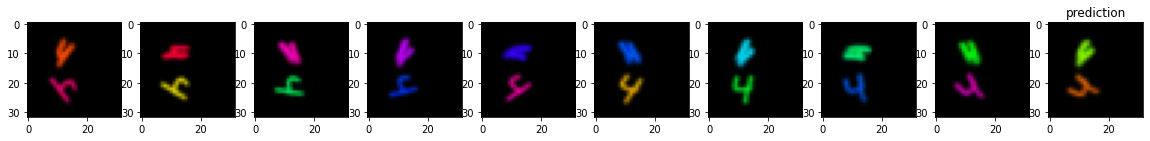

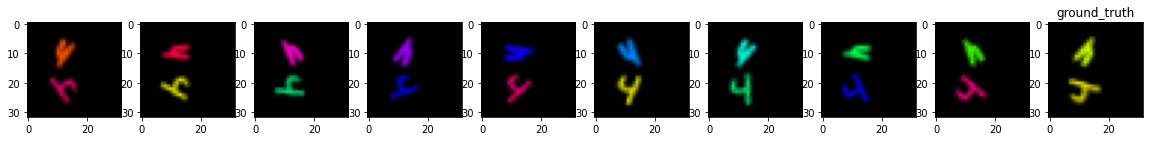

In [30]:
mysize= (20,20)
plt.figure(figsize=mysize)


for time in range(tp):
    plt.subplot(1, tp, time+1)
    plt.imshow(xs_pred[check_idx][time].permute([1,2,0]).to('cpu').detach()) 
plt.title('prediction')

plt.figure(figsize=mysize)
for time in range(tp):
    plt.subplot(1, tp, time+1)
    plt.imshow(xs_target[check_idx][time].permute([1,2,0]).to('cpu').detach())
plt.title('ground_truth')


    
loss = torch.mean(torch.sum((xs_target - xs_pred) ** 2, axis=[2, 3, 4]))
print(loss)

In [17]:
# from tqdm import tqdm
predictive=True
n_cond = T_cond
reconstructive = False
predictive = False

# Mlist = []
# with torch.no_grad():
#     l2scores = []
#     for images in tqdm(train_loader):
#         if type(images) == list:
#             images = torch.stack(images)
#             images = images.transpose(1, 0)
#         # n t c w h
#         images = images.to(device)
#         if predictive == True or reconstructive == True:
#             images_target = images
#         else:
#             images_target = images[:, n_cond:n_cond + tp]
#         x_next, M = ev.predict(images, model, n_cond=n_cond,
#                                tp=tp, device=device,
#                                predictive=predictive,
#                                reconstructive=reconstructive)
#         l2_losses = torch.sum(
#             (images_target.to('cpu') - x_next.to('cpu')) ** 2,
#             axis=[-1, -2, -3])
#         l2scores.append(l2_losses)

#         Mlist.append(M.detach().to('cpu'))

#     Mlist = torch.cat(Mlist)

# l2scores = torch.cat(l2scores)
# av_l2 = torch.mean(l2scores, axis=0)
# av_l2var = torch.std(l2scores, axis=0)
# print(l2scores)

In [13]:
allresults, targ, xnext  = ev.prediction_evaluation([targdir_path], device =0, n_cond=2, tp=tp, repeats=1,predictive=False,reconstructive = False,alteration={})



{'args': {'T': 12, 'backgrnd': False, 'fixpos': True, 'max_T': 12, 'max_angle_velocity_ratio': [-0.5, 0.5], 'max_color_velocity_ratio': [-0.5, 0.5], 'only_use_digit4': True, 'pair_transition': False, 'root': '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/MNIST', 'same_object': False, 'train': True}, 'fn': './datasets/seq_mnist.py', 'name': 'SequentialMNIST_double'}
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221223_glasso_0/detach0_modeglasso 
 snapshot_model_iter_100000


100%|██████████| 183/183 [00:19<00:00,  9.50it/s]


tensor([ 0.7740,  1.9537,  5.1710,  7.2907,  8.5365, 10.6699, 13.3232, 14.7246,
        15.4895, 16.7498])


In [15]:
#targlist = ['detach0_modeglasso', 'detach0_modeexact']
result_dir = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result'
targpath = os.path.join(result_dir, '20221224_glasso_0')
targlist = os.listdir(targpath)


targdir_pathlist = [os.path.join(targpath, targdir) for targdir in targlist] 

In [ ]:
allresults, targ, xnext  = ev.prediction_evaluation(targdir_pathlist, device =0, n_cond=2, tp=tp, repeats=1,predictive=False,reconstructive = False,alteration={})



{'args': {'T': 12, 'backgrnd': False, 'fixpos': True, 'max_T': 12, 'max_angle_velocity_ratio': [-0.5, 0.5], 'max_color_velocity_ratio': [-0.5, 0.5], 'only_use_digit4': True, 'pair_transition': False, 'root': '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/MNIST', 'same_object': False, 'train': True}, 'fn': './datasets/seq_mnist.py', 'name': 'SequentialMNIST_double'}
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221224_glasso_0/modeglasso_lr005 
 snapshot_model_iter_100000


100%|██████████| 183/183 [00:21<00:00,  8.53it/s]


tensor([12.9218, 25.7430, 32.4254, 29.9813, 27.8849, 30.0470, 32.1933, 32.9625,
        33.4662, 33.9432])
{'args': {'T': 12, 'backgrnd': False, 'fixpos': True, 'max_T': 12, 'max_angle_velocity_ratio': [-0.5, 0.5], 'max_color_velocity_ratio': [-0.5, 0.5], 'only_use_digit4': True, 'pair_transition': False, 'root': '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/MNIST', 'same_object': False, 'train': True}, 'fn': './datasets/seq_mnist.py', 'name': 'SequentialMNIST_double'}
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221224_glasso_0/modeglasso_lr01 
 snapshot_model_iter_100000


100%|██████████| 183/183 [00:21<00:00,  8.51it/s]


tensor([14.6839, 30.4869, 33.4867, 33.3909, 34.3572, 34.7736, 34.8687, 34.9725,
        35.2566, 35.7000])
{'args': {'T': 12, 'backgrnd': False, 'fixpos': True, 'max_T': 12, 'max_angle_velocity_ratio': [-0.5, 0.5], 'max_color_velocity_ratio': [-0.5, 0.5], 'only_use_digit4': True, 'pair_transition': False, 'root': '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/MNIST', 'same_object': False, 'train': True}, 'fn': './datasets/seq_mnist.py', 'name': 'SequentialMNIST_double'}
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221224_glasso_0/modeexact_lr005 
 snapshot_model_iter_100000


100%|██████████| 183/183 [00:20<00:00,  8.85it/s]


tensor([15.0795, 21.1555, 27.3395, 29.0021, 27.9073, 28.0054, 29.3085, 29.4334,
        29.1342, 28.5232])
{'args': {'T': 12, 'backgrnd': False, 'fixpos': True, 'max_T': 12, 'max_angle_velocity_ratio': [-0.5, 0.5], 'max_color_velocity_ratio': [-0.5, 0.5], 'only_use_digit4': True, 'pair_transition': False, 'root': '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/MNIST', 'same_object': False, 'train': True}, 'fn': './datasets/seq_mnist.py', 'name': 'SequentialMNIST_double'}
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221224_glasso_0/modeexact_lr01 
 snapshot_model_iter_100000


  7%|▋         | 13/183 [00:02<00:19,  8.58it/s]

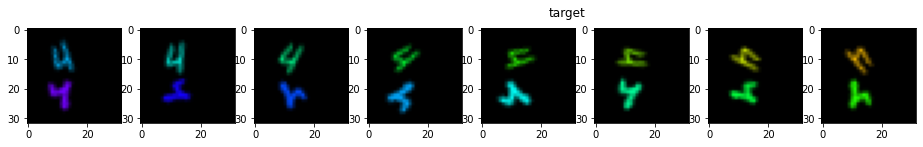

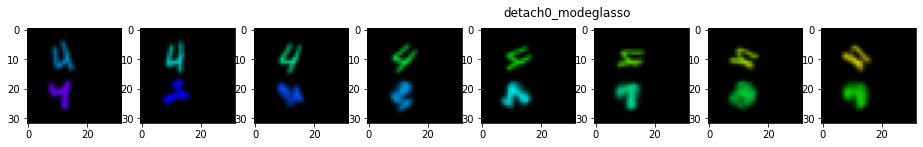

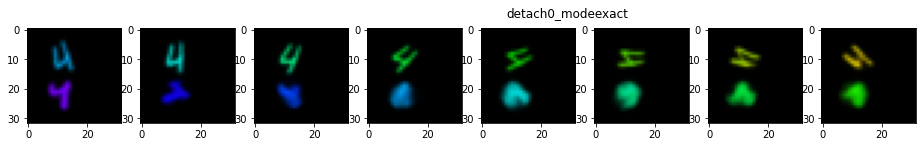

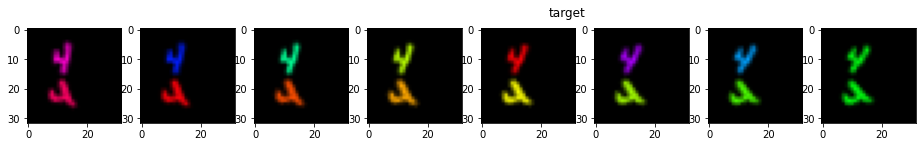

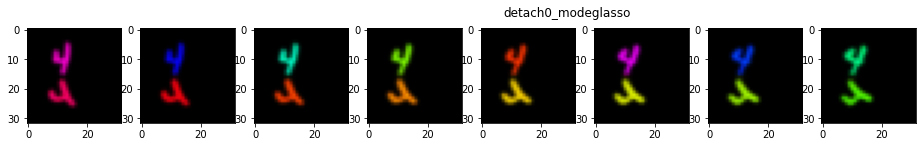

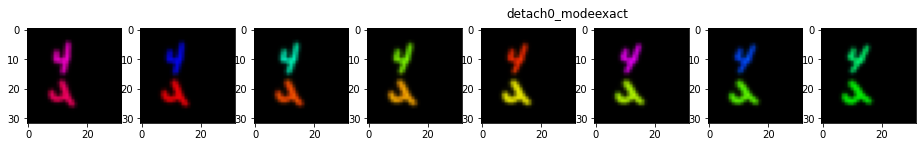

In [18]:

visualize_list = targdir_pathlist 

tp =10
device = 0
reload(sm)
for idx in list(range(0, 2)):
    figsize = (20,2)


    plt.figure(figsize = figsize)
    for k in range(tp-n_cond):
        tn = torch.permute(targ[idx][k+n_cond], (1,2,0))
        plt.subplot(1, tp, k+1)
        plt.imshow(tn, interpolation=None)
    plt.suptitle("target")  

    for mode in list(visualize_list):
        plt.figure(figsize = figsize)
        xnext, M = ev.predict(targ, allresults['models'][mode].to(device),
                    n_cond=2, tp=tp, device=device, swap =False,
                    predictive=False, reconstructive=False)
        xnext = xnext.to('cpu')
        M = M.to('cpu')
        for k in range(tp-n_cond):
            xn = torch.permute(xnext[idx][k], (1,2,0))
            plt.subplot(1, tp, k+1)
            plt.imshow(xn, interpolation=None)
        plt.suptitle(mode.split('/')[-1])    





In [20]:
mode = targdir_pathlist[0]


from utils import optimize_bd_cob as obc 
reload(obc)
Ms = allresults['Ms'][mode].to(device)
normalize=False
ChangeB= obc.optimize_bd_cob(Ms,  lr=0.1, epochs_monitor=20, n_epochs=100, normalize=True) 

ep:19 loss:8.82162059200266
ep:39 loss:8.81410206862486
ep:59 loss:8.81022830608764
ep:79 loss:8.80776104119306
ep:99 loss:8.805338150816537


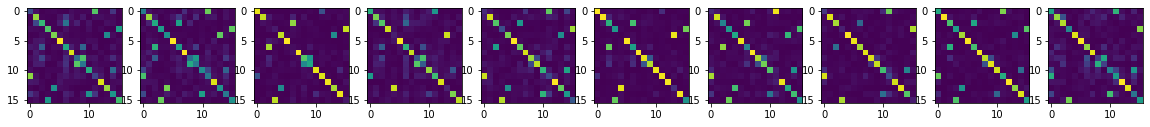

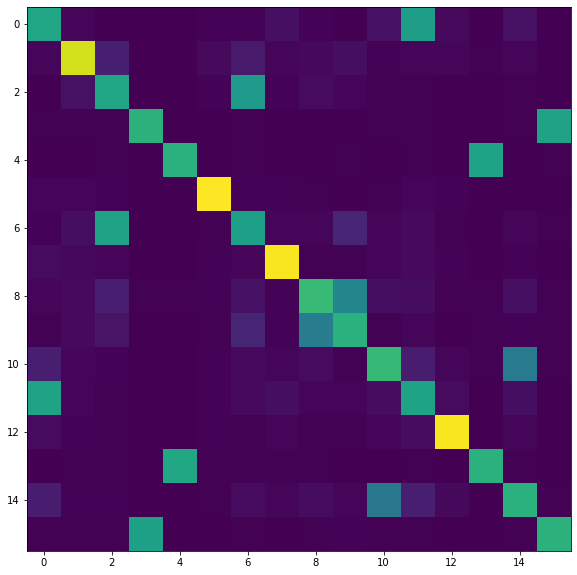

In [21]:
PMPs = ChangeB(Ms).to('cpu')
plt.figure(figsize=(20, 20))
for k in range(10):
    plt.subplot(1, 10, k+1)
    plt.imshow(torch.abs(PMPs[k]).detach().to('cpu'))
    
plt.figure(figsize=(10, 10))
plt.imshow(torch.mean(torch.abs(PMPs.detach()), axis=0))




In [22]:
reload(obc)
selections = obc.obtain_blocks(torch.mean(torch.abs(PMPs.detach()), axis=0), threshconst=0.5)
print(selections)

14 2 2
13 1 3
11 2 5
9 2 7
7 2 9
6 1 10
5 1 11
3 2 13
1 2 15
0 1 16
[[0, 11], [1], [2, 6], [3, 15], [4, 13], [5], [7], [8, 9], [10, 14], [12]]


/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221223_glasso_0/detach0_modeglasso


/tmp/ipykernel_32/1948386143.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(datseq1[k]).permute([1, 2, 0]))
/tmp/ipykernel_32/1948386143.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(datseq2[k]).permute([1, 2, 0]))


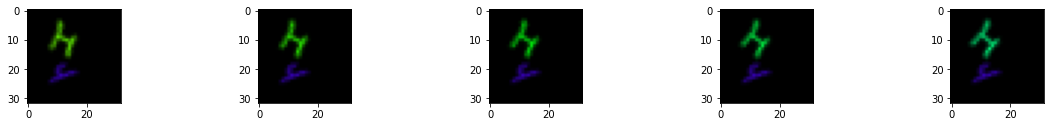

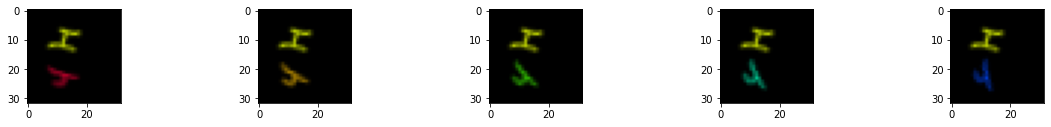

In [23]:
from utils import optimize_lasso as ol 
#import einops
reload(ol)
print(mode)
datseqs1, datseqs2 = ol.obtain_pair_sequences(mode, size=30, T=5)



idd = 3
datseq1= datseqs1[idd]
datseq2= datseqs2[idd]


plt.figure(figsize=(20,10))
for k in range(len(datseq1)):
    plt.subplot(5, len(datseq1),  k+1)
    plt.imshow(torch.tensor(datseq1[k]).permute([1, 2, 0])) 

plt.figure(figsize=(20,10))
for k in range(len(datseq2)):
    plt.subplot(5, len(datseq2),  k+1)
    plt.imshow(torch.tensor(datseq2[k]).permute([1, 2, 0])) 

In [24]:
checkmodel = allresults['models'][mode].to('cpu')
ChangeB = ChangeB.to('cpu')
encoded = checkmodel.encode(datseqs1).detach()
encoded_two = checkmodel.encode(datseqs2).detach()
print(datseqs1.shape)
print(datseqs2.shape)

print(encoded.shape)
print(encoded_two.shape)

encodedP = (encoded.to('cpu') @ ChangeB.U).detach()

encoded_twoP = (encoded_two.to('cpu') @ ChangeB.U).detach()




torch.Size([30, 5, 3, 32, 32])
torch.Size([30, 5, 3, 32, 32])
torch.Size([30, 5, 256, 16])
torch.Size([30, 5, 256, 16])


/tmp/ipykernel_32/3953994235.py:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(2, np.ceil(len(selections)/2), k)


torch.Size([240, 256])
torch.Size([120, 256])
torch.Size([240, 256])
torch.Size([240, 256])
torch.Size([240, 256])
torch.Size([120, 256])
torch.Size([120, 256])
torch.Size([240, 256])
torch.Size([240, 256])
torch.Size([120, 256])


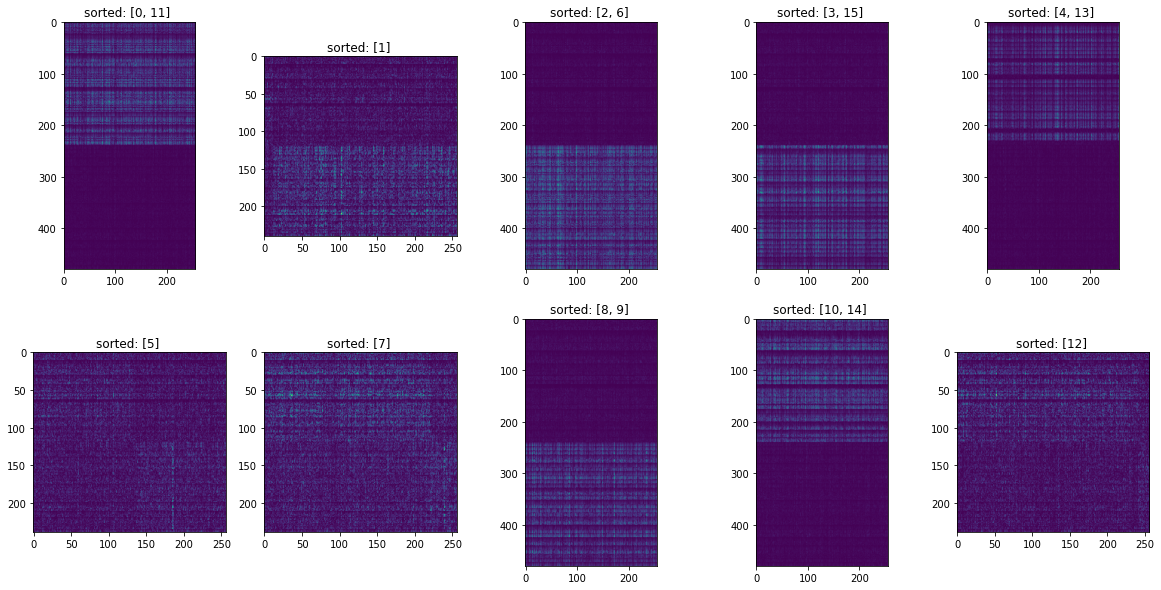

In [26]:
import einops
# k=1
# selection = selections[k]

chosen_selections = [] 
partitions = []
onewins = []
twowins = [] 

plt.figure(figsize=(20,10))
k=0
for selection in selections:

    k = k+1
    plt.subplot(2, np.ceil(len(selections)/2), k)
    
    delta_one_list = []
    delta_two_list = [] 
    for b in range(len(encodedP)):


        encodedU = encodedP[b, :, :, selection]
        encoded_twoU = encoded_twoP[b, :, :, selection]
        deltaU = encodedU[1:] - encodedU[0]
        deltaU = einops.rearrange(deltaU, 't s a -> (t a) s')
        delta_twoU = encoded_twoU[1:] - encoded_twoU[0]
        delta_twoU = einops.rearrange(delta_twoU, 't s a -> (t a) s')

        delta_one_list.append(deltaU)
        delta_two_list.append(delta_twoU)

    #Shall be [b x (T-1) x (dimI)]  x dimS
    delta_one = torch.cat(delta_one_list)
    delta_two = torch.cat(delta_two_list)
    print(delta_one.shape)


    
    #sort
    delta_sort, delta_two_sort, (onewin, twowin) = ol.sort_pair_col(delta_one, delta_two)
    plt.imshow(torch.cat([torch.abs(delta_sort.detach().to('cpu')),  torch.abs(delta_two_sort.detach().to('cpu'))]  ))
    plt.title(f"""sorted: {selection} """)
    #Record
    chosen_selections.append(selection)
    partitions.append([onewin] + [twowin] )
    onewins.append(onewin)
    twowins.append(twowin)



In [35]:
mode

'/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221223_glasso_0/detach0_modeglasso'